# Lunar lander

Analytic example from Darby paper on mesh adaptation

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from archimedes.experimental import coco as cc

%load_ext autoreload
%autoreload 2

In [2]:
nx, nu = 2, 1
x0 = np.array([10.0, -2.0])
xf = np.array([0.0, 0.0])
t0, tf = 0.0, 4.0
g = 1.5


def j(t, x, u, p):
    return u


def f(t, x, u, p):
    return np.array([x[1], -g + u[0]], like=x)


def cost(x0, t0, xf, tf, q, p):
    return q


# Discretize the domain
N = [10]
knots = []

boundary_conditions = [
    cc.start_time(t0),
    cc.initial_condition(x0),
    cc.final_condition(xf),
]

path_constraints = [cc.control_bounds([0.0], [3.0])]

# Define the optimal control problem
ocp = cc.OptimalControlProblem(
    nx=2,
    nu=1,
    ode=f,
    quad=j,
    cost=cost,
    boundary_constraints=boundary_conditions,
    path_constraints=path_constraints,
)


# Linearly interpolate initial guess
def x_guess(t):
    return x0 + (t - t0) * (xf - x0) / (tf - t0)

In [3]:
# Initial solution
domain = cc.RadauFiniteElements(N=[5], knots=[])
sol = ocp.solve(
    domain,
    t_guess=(t0, tf),
    x_guess=x_guess,
    ipopt={"print_level": 0},
    print_time=0,
)
converged = False
max_iter = 50

# Refine
for i in range(max_iter):
    print(f"\n*** Iteration {i + 1} ***")

    # sol = ocp.solve(domain, t_guess=(t0, tf), x_guess=x_guess)
    # sol = ocp.solve(domain, t_guess=(t0, tf), x_guess=x_guess, print_level=0, print_time=0)
    residuals = cc.midpoint_residuals(ocp, domain, sol)
    converged, domain = cc.refine_mesh_bisection(
        domain,
        residuals,
        eps=1e-6,
        incr=3,
        rho=2,
        verbose=True,
    )
    sol = ocp.solve(
        domain,
        t_guess=(sol.t0, sol.tf),
        x_guess=sol.x,
        u_guess=sol.u,
        ipopt={"print_level": 0},
        print_time=0,
    )

    if converged:
        break


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************


*** Iteration 1 ***
(4, 2) (4,) (4,)
(4, 1) (4,) (4,)
Element 0: residual (max/avg) = 2.55e-01/1.67e-01, max scaled = 1.53e+00
New domain: [8], knots=[]
(2, 2) (1,) (1,)
(1, 1) (1,) (1,)

*** Iteration 2 ***
(7, 2) (7,) (7,)
(7, 1) (7,) (7,)
Element 0: residual (max/avg) = 3.91e-02/2.16e-02, max scaled = 1.81e+00
New domain: [11], knots=[]
(2, 2) (1,) (1,)
(1, 1) (1,) (1,)

*** Iteration 3 ***
(10, 2) (10,) (10,)
(10, 1) (10,) (10,)
Element 0: residual (max/avg) = 2.71e-02/1.33e-02, max scaled = 2.04e+00
	Splitting at τ=0.0
New domain: [3, 3], knots=[np.float64(0.0)]
(2, 2) (1,) (1,)
(1, 1) (1,) (1,)

***

(2000, 2) (2000,) (2000,)
(2000, 1) (2000,) (2000,)


/var/folders/s6/pyplp64s6cg0fs1312qb3pnh0000gn/T/ipykernel_53482/3703850239.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()
/var/folders/s6/pyplp64s6cg0fs1312qb3pnh0000gn/T/ipykernel_53482/3703850239.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


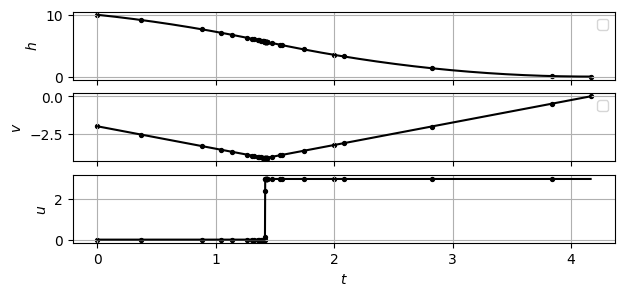

In [4]:
t_plt = np.linspace(sol.t0, sol.tf, 2000)
x_plt = sol.x(t_plt)
u_plt = sol.u(t_plt)

fig, ax = plt.subplots(3, 1, figsize=(7, 3), sharex=True)
ax[0].scatter(sol.tp, sol.xp[:, 0], c="k", s=8)
ax[0].plot(t_plt, x_plt[:, 0], c="k")
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel(r"$h$")
ax[1].scatter(sol.tp, sol.xp[:, 1], c="k", s=8)
ax[1].plot(t_plt, x_plt[:, 1], c="k")
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel(r"$v$")
ax[2].scatter(sol.tp[:-1], sol.up, c="k", s=8)
ax[2].plot(t_plt, u_plt, c="k")
ax[2].grid()
ax[2].set_ylabel(r"$u$")
ax[2].set_xlabel(r"$t$")
# ax[2].set_xlim([1.36, 1.45])

plt.show()

In [5]:
# Analytic solution
h0, v0 = x0
tf_opt = (2 * v0) / 3 + 4 * np.sqrt(0.5 * v0**2 + 1.5 * h0) / 3
s_opt = 0.5 * tf_opt + v0 / 3  # Optimal switching time


def h1(t):
    return -0.75 * t**2 + v0 * t + h0


def v1(t):
    return -1.5 * t + v0


def h2(t):
    return 0.75 * t**2 + (v0 - 3 * s_opt) * t + 1.5 * s_opt**2 + h0


def v2(t):
    return 1.5 * t + v0 - 3 * s_opt


print(f"Optimal time: {tf_opt:.4f}")
print(f"Optimal switching time: {s_opt:.4f}")

Optimal time: 4.1641
Optimal switching time: 1.4154
